This notebook produces graphics showing the geographical extent of the default cutouts

In [82]:
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import matplotlib.pyplot as plt
import atlite
import xarray as xr

In [14]:
STATES_TO_REMOVE = [
    "Hawaii", 
    "Alaska", 
    "Commonwealth of the Northern Mariana Islands", 
    "United States Virgin Islands", 
    "Guam", 
    "Puerto Rico", 
    "American Samoa"
]

In [18]:
shpfilename = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_1_states_provinces"
)
reader = shpreader.Reader(shpfilename)
gdf_states = reader.records()
data = []
for r in gdf_states:
    attr = r.attributes
    if (attr["iso_a2"] in ["US"]) and (attr["name"] not in STATES_TO_REMOVE):
        data.append([attr["name"], attr['iso_a2'], attr["latitude"], attr["longitude"], r.geometry])
gdf_states = gpd.GeoDataFrame(data, columns=["name", "country", "x", "y", "geometry"]).set_crs(4326)

In [55]:
cutout_western = "./../cutouts/western_era5_2019.nc"
cutout_eastern = "./../cutouts/eastern_era5_2019.nc"
cutout_texas = "./../cutouts/texas_era5_2019.nc"
# cutout_usa = 

In [52]:
def plot_cutout(cutout, gdf, title):
    fig, ax = plt.subplots(figsize=(12, 8), dpi=80)
    ax.axis("off")
    cutout = atlite.Cutout(cutout)
    gdf.plot(ax=ax)
    cutout.grid.plot(edgecolor="white",linewidth=0.8,alpha=0.25, color="red", ax=ax)
    # Add x and y labels
    ax.set_title(title, fontsize = 20)

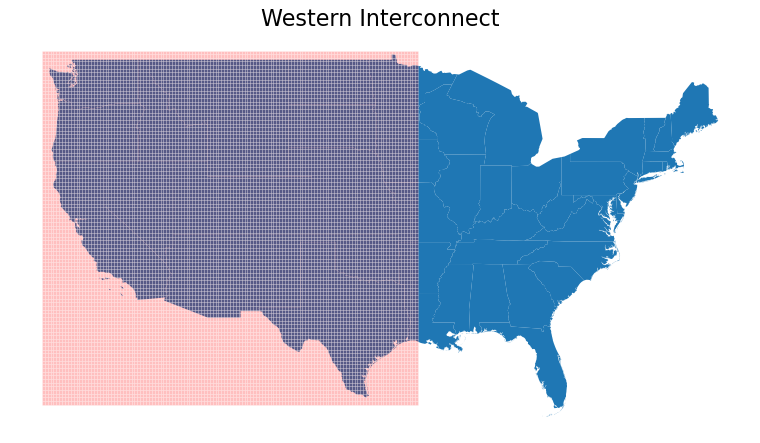

In [49]:
plot_cutout(cutout_western, gdf_states, "Western Interconnect")

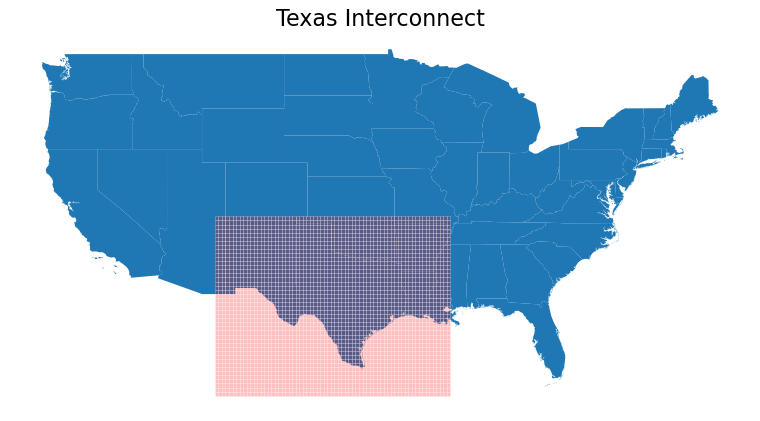

In [53]:
plot_cutout(cutout_texas, gdf_states, "Texas Interconnect")

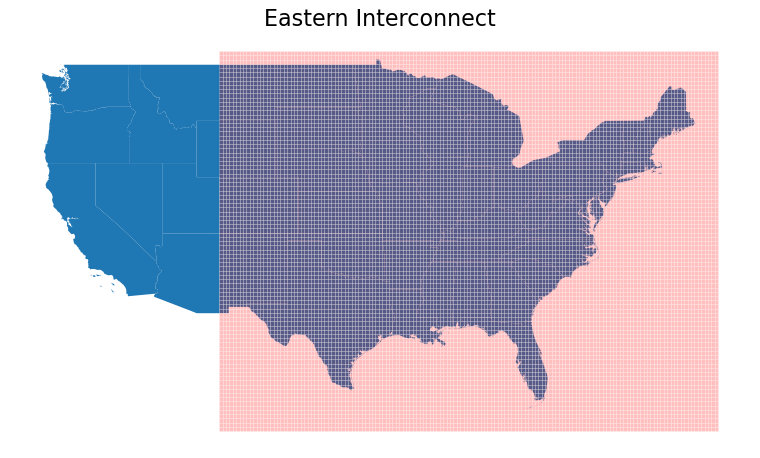

In [56]:
plot_cutout(cutout_eastern, gdf_states, "Eastern Interconnect")

In [128]:
units_mapper = {
    "height":"m",
    "wnd100m":"ms**-1",
    "wnd_azimuth":"m s**-1",
    "roughness":"m",
    "influx_toa":"Wm**-2",
    "influx_direct":"Wm**-2",
    "influx_diffuse":"Wm**-2",
    "albedo":"-",
    "solar_altitude":"rad",
    "solar_azimuth":"rad",
    "temperature":"K",
    "soil temperature":"K",
    "runoff":"m",
}

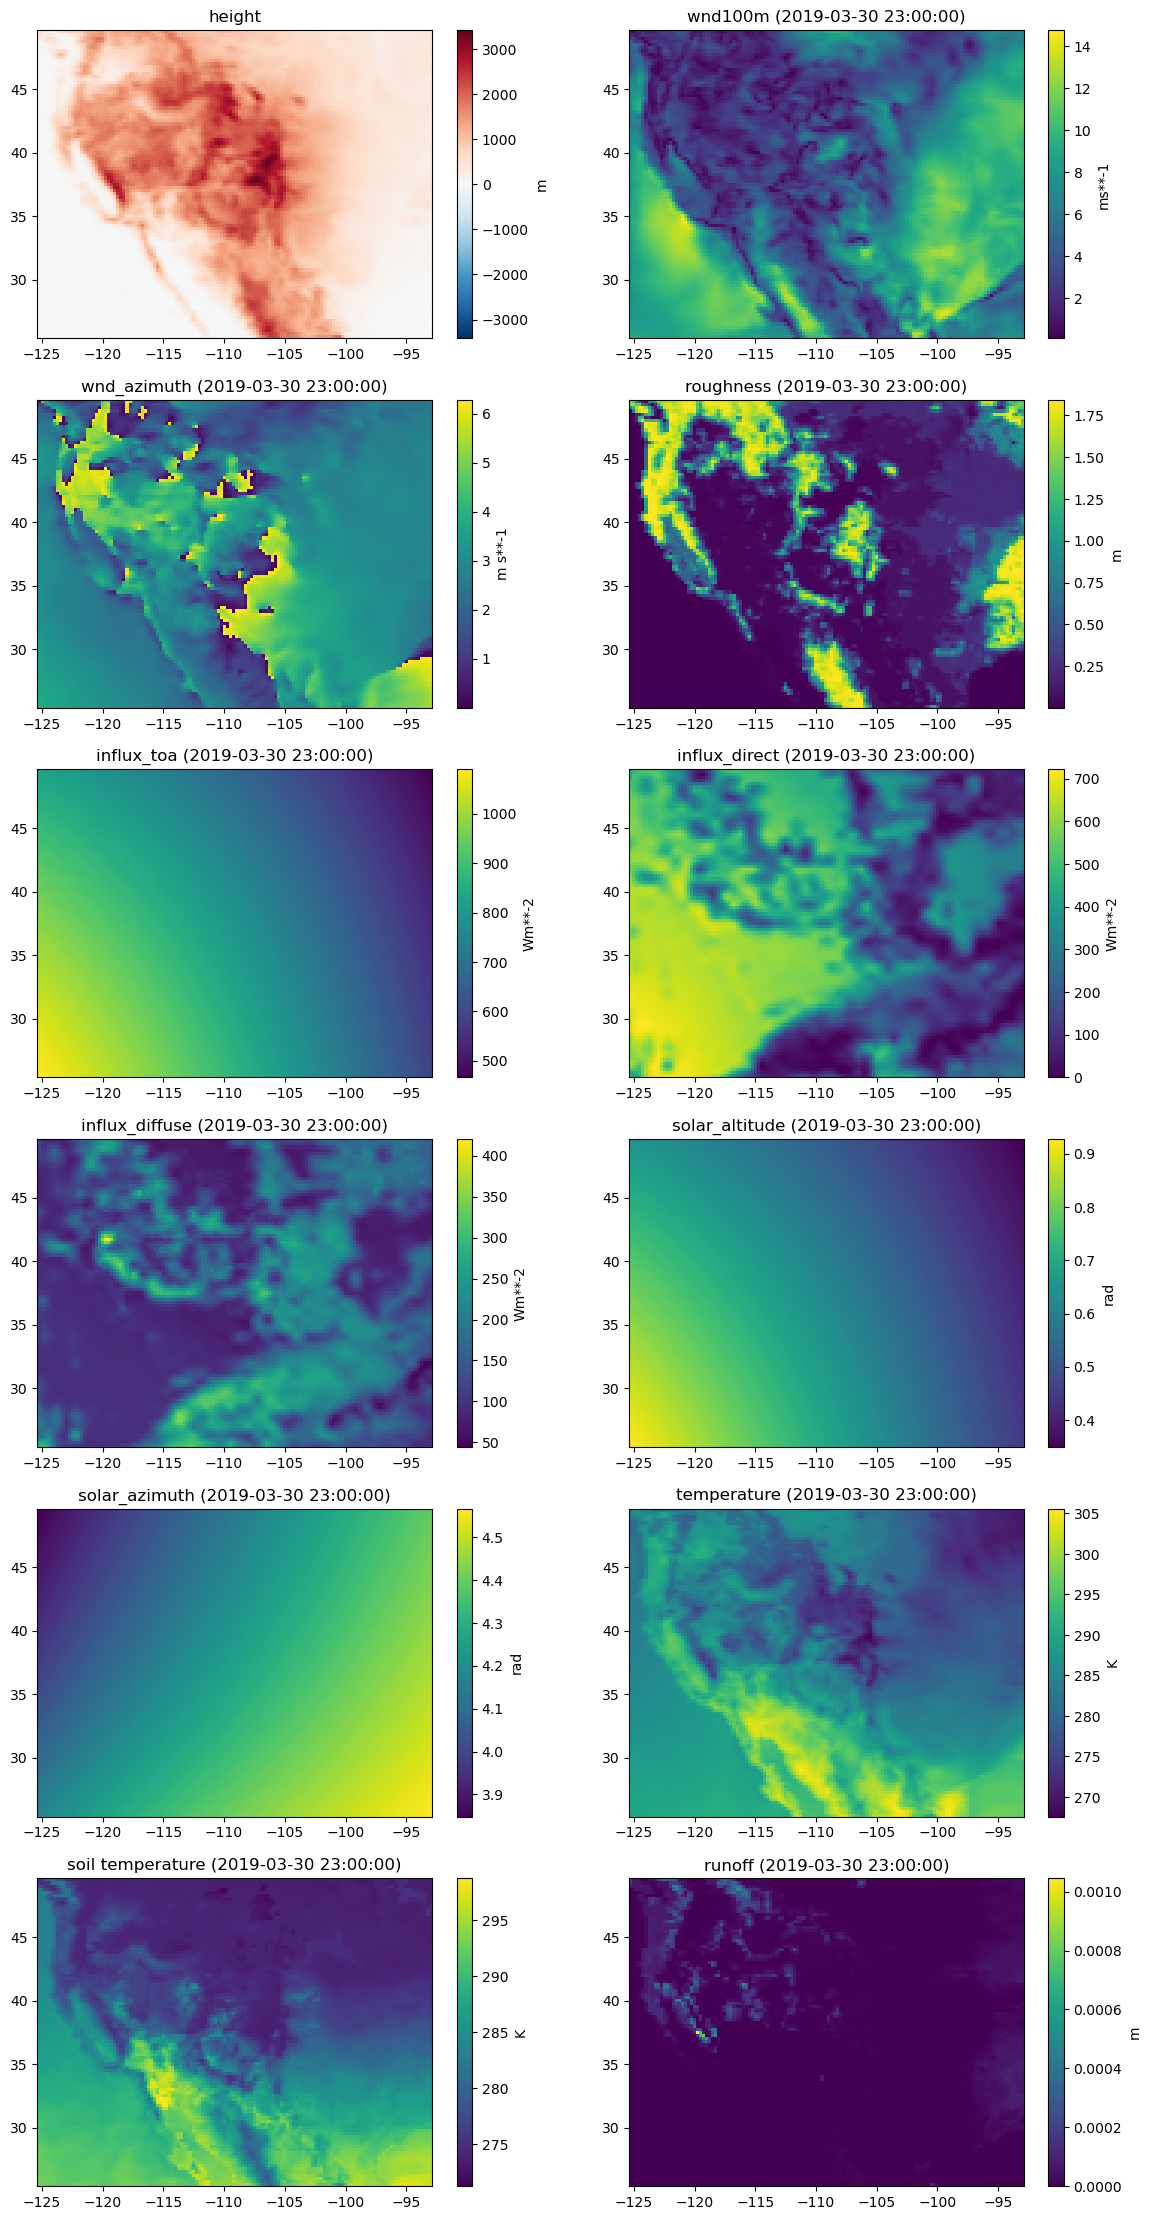

In [133]:
cutout = atlite.Cutout(cutout_western)
time_to_plot = "2019-03-30 23:00:00"
# cutout.data.wnd100m.sel(time="2019-03-30 23:00:00").plot()
ax_idx = 0
ax_idy = 0
fig, axs = plt.subplots(6, 2, figsize=(14, 28))
for var in cutout.data.data_vars:
    if var == "albedo":
        continue
    if "time" in cutout.data[var].coords:
        cutout.data[var].sel(time=time_to_plot).plot(ax=axs[ax_idy, ax_idx], cbar_kwargs={"label": units_mapper[var]})
        axs[ax_idy, ax_idx].set_title(f"{var} ({time_to_plot})")
    else:
        cutout.data[var].plot(ax=axs[ax_idy, ax_idx], cbar_kwargs={"label": units_mapper[var]})
        axs[ax_idy, ax_idx].set_title(f"{var}")
    
    axs[ax_idy, ax_idx].set_ylabel("")
    axs[ax_idy, ax_idx].set_xlabel("")
    
    ax_idx = (ax_idx + 1) % 2
    if ax_idx == 0:
        ax_idy += 1